### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 7
### Due: Saturday, Mar 30th at 11.59pm CT
---

This is a regression problem. Many of the parts require minor variations of code to switch to new techniques, but otherwise using a similar workflow. 

Note of warning: the data I have provided have associated uncertainties, `yerr`. `sklearn` and `astroML` have different formats for using uncertainties; in `sklearn` fitting you can provide `sample_weight=1/yerr**2`, while in `astroML` fitting you can directly provide `y_error=yerr`.

1. Read in `hw7_data_1.npy`. The dataset should consist of $500$ samples. The first two columns are the two data features, `X`. The third column is the target labels, `y`, and the final column are the heteroscedastic uncertainties on the labels, `yerr`. Make a 2-panel scatter plot of the labels versus each feature.


2. Use multivariate linear regression on this data with its uncertainties (`astroML` rather than plain `sklearn` is the better option here). Print the best-fit intercept and slopes for the features. Make a prediction `Xgrid` over $50$ values from the min to the max value of each feature, and plot the best-fit model on a duplicate of the $2$-panel plot from (1); does this look like a good description of the data?


3. Make a new two-dimensional prediction meshgrid `Xgrid` over the $2$-D feature space, use your best-fit model to predict the labels, and make a $3$-D interactive plot showing the data and your best-fit over the entire space. You may find the following code useful.

In [1]:
# install the relevant interactive plot packages
# only do this once
!pip install ipywidgets ipympl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 5.0 MB/s eta 0:00:00a 0:00:01


In [ ]:
# Makes the plot interactive. 
# You can pan the image.

### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(___, ___, y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(___.flatten(), ___.flatten(), ___, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)

In [ ]:
### Always do this line at the start
### of a static plotting cell
%matplotlib inline

4. Sticking with a linear model, now attempt a `GridSearchCV` procedure on the data to find the best `Ridge` regression hyper-parameters. Use the following `param_grid`:
```
ridge_params = {'alpha': [0.05,0.1,0.2,0.5,1.0], 'solver': ['svd', 'lsqr']}
```
What are the `best_params_` and the `best_score_` from this? Fit the data with the best options, and visualize interactively. Try `RidgeCV` also; what cross-validated `alpha_` does it return, and does this agree with `GridSeachCV`? *(Hint: remember to revert to inline matplotlib when you're done each time you make an interactive plot.)*


5. Now model the data using Gaussian process regression and the default kernel. Check what the fit looks like with and with and without uncertainties accounted for. *(Hint: GPR in `sklearn` takes an `alpha` parameter equal to `(yerr/y)**2`.)*


6. Let's look finally at polynomial fitting. Fit a $4$th degree polynomial to the data. Print the best-fit regression coefficients, predict on the 2D meshgrid, and visualize interactively as before. How does this look compared to the linear model and GPR models?


7. Sticking with polynomial fitting, let's find the optimal hyper-parameters through cross-validation. 
- Using `sklearn.model_selection.train_test_split`, first do a train-test split with a `test_size` of $20\%$. Then split out $20\%$ of the training set itself as a cross-validation set (leaving a somewhat smaller set to use for training). Note that you'll need to simultaneously split out `yerr` as well by just providing this as another array to `train_test_split`.
- Compute the training and cross-validation rms errors (and from those, the BIC values) as a function of polynomial degree from $1$ to $10$ inclusive. Plot the rms errors and BIC values as a function of the polynomial degree. 
- Choose the optimal polynomial degree, and train on all training data from the first `train_test_split` operation. Predict the labels of the held-out test set, and finally compute the testing rms error.

## Part 1:

In [3]:
# Read in `hw7_data_1.npy`. The dataset should consist of $500$ samples. The first two columns are the two data features, `X`. 
#The third column is the target labels, `y`, and the final column are the heteroscedastic uncertainties on the labels, `yerr`. 
#Make a 2-panel scatter plot of the labels versus each feature.

#importing tools
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sklearn

data = np.load('/home/nowickr/astr_8070_s24/coursework/homeworks/hw_data/hw7_data_1.npy')
data.shape

(500, 4)

In [4]:
X = data[:,:2] #first two columns (0,1) are data X
y = data[:,2]  #third column is labels y
yerr = data[:,3] #fourth column in uncertainties on the labels, yerr

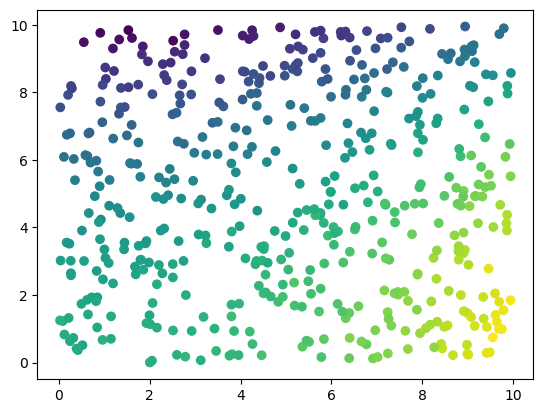

In [5]:
#plotting scatterplot
plt.scatter(X[:,0],X[:,1], c=y)

#making two subplots with X[0] vs y and X[1] vs y

## Part 2:

In [ ]:
#Use multivariate linear regression on this data with its uncertainties (`astroML` rather than plain `sklearn` is the better option here). 
#Print the best-fit intercept and slopes for the features. Make a prediction `Xgrid` over $50$ values from the min to the max value of each feature, 
# and plot the best-fit model on a duplicate of the $2$-panel plot from (1); does this look like a good description of the data?


## Part 3:

In [ ]:
#Make a new two-dimensional prediction meshgrid `Xgrid` over the $2$-D feature space, use your best-fit model to predict the labels, 
# and make a $3$-D interactive plot showing the data and your best-fit over the entire space. You may find the following code useful.

## Part 4:

## Part 5:

## Part 6:

## Part 7: